In [9]:
import ROOT as M
import numpy as np
import scipy.optimize as op
from scipy.interpolate import RectBivariateSpline
import sys
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('thomas')
import time
from astropy.time import Time
from astropy.stats import bayesian_blocks

from COSIpy_tools import * # specific routines for use with COSI and MEGAlib data
#from model_definitions import * # models to be used with emcee

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook as tqdm
from IPython.display import Image

import emcee
import corner

# Load MEGAlib into ROOT
M.gSystem.Load("$(MEGAlib)/lib/libMEGAlib.so")

# Initialize MEGAlib
G = M.MGlobal()
G.Initialize()

True

In [12]:
dir = 'datasets/9det_nova/'
COSI_Data_sim_nova9 = read_COSI_DataSet(dir)

In [13]:
len(COSI_Data_sim_nova9[0]['TimeTags'])

97

In [14]:
fisbelbins = FISBEL(1650,0)
bb = (np.array(fisbelbins[0]))[:,0]#-np.pi/2.
ll = (np.array(fisbelbins[0]))[:,1]#-np.pi

dbb = (np.array(fisbelbins[1]))[:,0].reshape(1650,)
dll = (np.array(fisbelbins[1]))[:,1].reshape(1650,)

pp_edges = np.linspace(0,np.pi,37)
pp_min = pp_edges[0:-1]
pp_max = pp_edges[1:]
pp = (pp_max+pp_min)/2.
dpp = (pp_max-pp_min)

In [15]:
tdx_sim_nova9 = np.array(hourly_tags(COSI_Data_sim_nova9))
tdx_sim_nova9 = tdx_sim_nova9.reshape(1,24)
sim_data_nova9 = hourly_binning(COSI_Data_sim_nova9)
binned_data_sim_nova9 = get_binned_data_complete(COSI_Data_sim_nova9,pp,bb,ll,dpp,dbb,dll)

In [16]:
np.sum(binned_data_sim_nova9)

97.0

In [49]:
sim_source = -1.23, -4.5

In [50]:
"""np.savez('binned_data_511_sim_nova_only',binned_data_sim_nova_only=binned_data_sim_nova_only)""";

In [19]:
"""with np.load('binned_data_511_sim_bg_only.npz') as content:
    binned_data_sim_bg_only = content['binned_data_sim_bg_only']""";

In [20]:
with np.load('binned_data_511_GTI.npz') as content:
    binned_data_GTI = content['binned_data_GTI']

In [21]:
binned_data_sim_nova9.shape

(36, 1650)

In [22]:
binned_data_GTI.shape

(47, 24, 36, 1650)

In [23]:
tdx_sim_nova9.shape

(1, 24)

In [24]:
with np.load('response/ResponseGrid511_v3.npz',) as content:
    ResponseGrid1 = content['response_grid_normed']
    l3cen = content['l3cen']
    b3cen = content['b3cen']
    l3wid = content['l3wid']
    b3wid = content['b3wid']
    L3 = content['L3']
    B3 = content['B3']

In [25]:
from scipy.interpolate import RectBivariateSpline
from tqdm import tqdm_notebook as tqdm

threshold = 0.

nzero = 0
nnonzero = 0

tstart = time.time()

FullInterpolatedPSResponseBivar = []
for i in tqdm(range(ResponseGrid1.shape[2])):
    for j in range(ResponseGrid1.shape[3]):
        if (np.nansum(ResponseGrid1[:,:,i,j]) < threshold):
            FullInterpolatedPSResponseBivar.append(zero_func)
            nzero += 1
        else:
            FullInterpolatedPSResponseBivar.append(RectBivariateSpline(b3cen,l3cen,ResponseGrid1[:,:,i,j]))
            nnonzero += 1

In [26]:
background_response_full = np.nansum(binned_data_GTI[:,:,:,:],axis=(0,1)).ravel()
background_response_full = background_response_full/np.nansum(background_response_full)

In [27]:
background_response_full.shape

(59400,)

In [28]:
NonZeroResponseGrid = ResponseGrid1.reshape(36,72,59400)

In [29]:
calc_this = np.where(background_response_full != 0)[0].astype(int)

NonZeroInterpolatedPSResponseBivar = []
for c in calc_this:
    NonZeroInterpolatedPSResponseBivar.append(FullInterpolatedPSResponseBivar[c])
    
background_response = background_response_full[calc_this]

NonZeroResponseGrid = (ResponseGrid1.reshape(36,72,59400))[:,:,calc_this]

arbdim = np.arange(1650*36)
arbdim2 = arbdim[calc_this]

In [30]:
calc_this.shape

(4587,)

In [31]:
binned_data_sim_nova9.shape

(36, 1650)

In [32]:
background_response.shape

(4587,)

In [51]:
zs = np.rad2deg(COSI_Data_sim_nova9[0]['Zpointings'])
xs = np.rad2deg(COSI_Data_sim_nova9[0]['Xpointings'])
ys = np.rad2deg(COSI_Data_sim_nova9[0]['Ypointings'])

zens,azis = zenazi(xs[:,0],
               xs[:,1],
               ys[:,0],
               ys[:,1],
               zs[:,0],
               zs[:,1],
               sim_source[0],
               sim_source[1])

sky_response_sim = np.mean(get_response_with_weights(NonZeroResponseGrid,zens,azis,cut=60),axis=0)

In [52]:
zs = np.rad2deg(COSI_Data_sim_nova9[0]['Zpointings'])
xs = np.rad2deg(COSI_Data_sim_nova9[0]['Xpointings'])
ys = np.rad2deg(COSI_Data_sim_nova9[0]['Ypointings'])

zens,azis = zenazi(xs[:,0],
               xs[:,1],
               ys[:,0],
               ys[:,1],
               zs[:,0],
               zs[:,1],
               30,
               40)

sky_response_off = np.mean(get_response_with_weights(NonZeroResponseGrid,zens,azis,cut=60),axis=0)

In [53]:
flux = 1.0e-2
hours = 10
Tobs = 3600 * hours
Abg = 100. * hours

In [54]:
np.sum(background_response)*Abg,np.sum(sky_response_sim)*flux*Tobs

(1000.0, 312.16630950739153)

In [55]:
# only use the non-zero entries
tmp_data = np.random.poisson(sky_response_sim*flux*Tobs + background_response*Abg)
# cross-check number of photons simulated
print(np.sum(tmp_data))

# set 4 dimensions, one for each fit parameters
# 20 walkers >> 4 dimensions
ndim, nwalkers = 4, 20
# initial guess, here close to the true values
guess = np.array([flux,Abg, sim_source[0], sim_source[1]])
# add random points around that guess for each walker differently
pos = guess[:, None] + np.random.randn(ndim,nwalkers)*np.repeat([1e-4,1,1,1],nwalkers).reshape(ndim,nwalkers)
pos = pos.T

# make sure we use the correct observation again
zs = np.rad2deg(COSI_Data_sim_nova9[0]['Zpointings'])
xs = np.rad2deg(COSI_Data_sim_nova9[0]['Xpointings'])
ys = np.rad2deg(COSI_Data_sim_nova9[0]['Ypointings'])

# set up sampler
sampler = emcee.EnsembleSampler(nwalkers,
                                ndim,
                                lnprob_PSsearchFlux,
                                args=(tmp_data,
                                      NonZeroResponseGrid,
                                      xs,ys,zs,
                                      background_response,
                                      Tobs,False)) # set up sampler
# sample
_ = sampler.run_mcmc(pos, 300, progress=True) # sample

1287


100%|██████████| 300/300 [01:25<00:00,  3.21it/s]


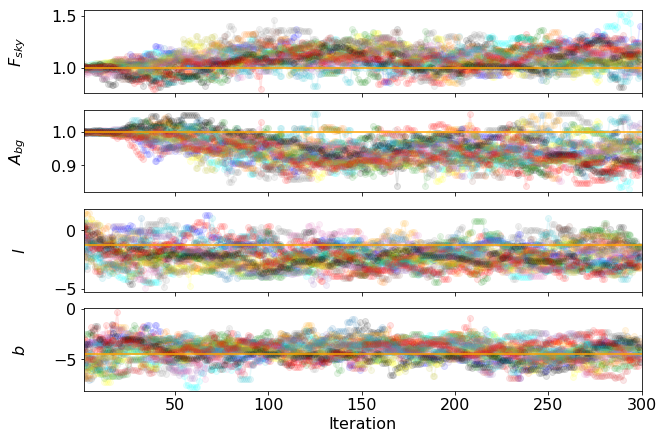

In [56]:
scl = [1e2,1e-3,1,1]
fig, axes = plt.subplots(ndim, figsize=(ndim*2.5, 7), sharex=True)
samplesg = sampler.get_chain()*scl
labels = ["$F_{sky}$", "$A_{bg}$", "$l$", "$b$"]
truths = np.array([flux,Abg,sim_source[0],sim_source[1]])*scl
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.arange(len(samplesg)),samplesg[:, :, i], alpha=0.1,marker='o')
    ax.set_xlim(1, len(samplesg))
    ax.plot([1,len(samplesg)],[truths[i],truths[i]],color='orange')
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    #ax.set_xscale('log')

axes[-1].set_xlabel("Iteration");

Text(0, 0.5, 'Log(Posterior probability)')

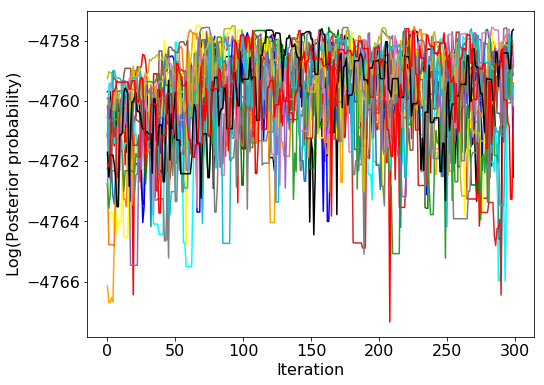

In [57]:
samplesf = sampler.flatchain
samplesf.shape
plt.plot(sampler.lnprobability)
plt.xlabel('Iteration')
plt.ylabel('Log(Posterior probability)')

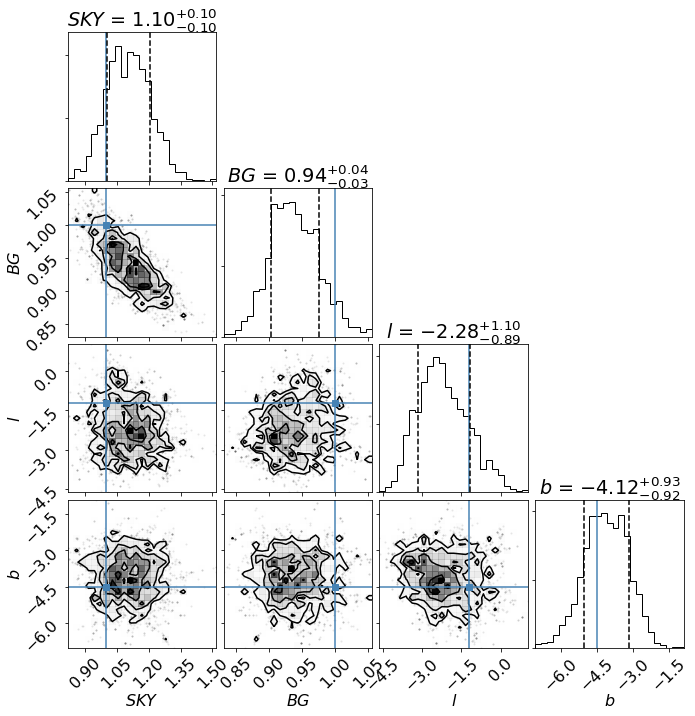

In [58]:
tmp = corner.corner(samplesf[100*nwalkers:,:]*scl, labels=["$SKY$","$BG$", "$l$", "$b$"],
                    truths=truths,
                    quantiles=[0.5-0.683/2,0.5+0.683/2],show_titles=True,
                    #range=[(0.5,1.5),(-1,15),(-7,4),(-15,1)],
                    bins=25)
tmp.set_size_inches(10,10)

<h3>Simulate sources (Tobs = 1 hour) for different zenith angles (0 -- 60 deg) in steps of 8 deg for four different significances (3, 5, 10, 30 sigma), and for low (Abg = 100) and high (Abg = 10000) background:</h3>

In [59]:
lzm = minmax(zs[:,0])
bzm = minmax(zs[:,1])

In [60]:
lzmean = np.mean(zs[:,0])
bzmean = np.mean(zs[:,1])

In [61]:
l0,b0 = lzmean,bzmean

In [127]:
# Average observation position (=zenith)
lzmean = np.mean(zs[:,0])
bzmean = np.mean(zs[:,1])
l0,b0 = lzmean,bzmean
# Tested zenith angles:
zeniths = np.arange(0,64,8)
# Tested source significances (approximately)
sigmas = np.array([3,5,10,30.])
# "low" BG amplitude
Abg_lo = 100.
# "high" BG amplitude
Abg_hi = 1e4
# "Standard" observation time
Tobs0 = 3600 # seconds

In [128]:
# Flux array to estimate significance given background amplitude, observation time, and response for zenith
# get sky responses for chosen zeniths (random points)
response_norms_zeniths = np.zeros(len(zeniths))
for i in range(len(zeniths)):
    # get random point around on a circle around middle point
    tmp_circle = np.column_stack(circle_on_the_sky(l0,b0,zeniths[i]))
    tmp_randp = tmp_circle[np.random.randint(100,size=1)[0],:]
    # calculate zeniths again
    zens,azis = zenazi(xs[:,0],xs[:,1],
                       ys[:,0],ys[:,1],
                       zs[:,0],zs[:,1],
                       tmp_randp[0],tmp_randp[1])
    # and sky response
    tmp_sky_response = np.mean(get_response_with_weights(NonZeroResponseGrid,zens,azis,cut=60),axis=0)
    # calculate total effective area
    sum_tmp_sky_response = np.sum(tmp_sky_response)
    response_norms_zeniths[i] = sum_tmp_sky_response


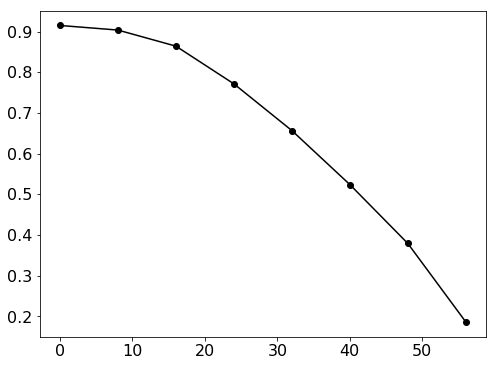

In [129]:
plt.plot(zeniths,response_norms_zeniths,'o-')

In [130]:
zeniths

array([ 0,  8, 16, 24, 32, 40, 48, 56])

<h5>Solving for flux in Li&Ma significance estimate is not possible analytically, check values by minimising towards desired significance:</h5>

In [131]:
def min_func(f, sigma, Abg, response_norms_zeniths, Tobs0):
    func = lambda f: lima_significance(Abg+response_norms_zeniths*Tobs0*f,Abg,1)
    return np.sqrt((func(f)-sigma)**2)

In [134]:
to_min = lambda *args: min_func(*args)

In [148]:
fluxes_to_test = np.zeros((len(zeniths),len(sigmas),2))
for a in range(2):
    if a == 0:
        A = Abg_lo
    else:
        A = Abg_hi
    for z in range(len(zeniths)):
        for s in range(len(sigmas)):
            result = op.minimize(to_min, [1e-2], args=(sigmas[s],A,response_norms_zeniths[z],Tobs0), method='Nelder-Mead')
            fluxes_to_test[z,s,a] = result.x

In [150]:
fluxes_to_test[:,:,0]

array([[0.01426367, 0.02536133, 0.05894141, 0.2845625 ],
       [0.01444238, 0.02567871, 0.05967773, 0.28813281],
       [0.01510156, 0.02685156, 0.06241016, 0.30131641],
       [0.01691797, 0.03007813, 0.0699043 , 0.33750781],
       [0.019875  , 0.03533594, 0.082125  , 0.39650391],
       [0.02491016, 0.04428711, 0.10292578, 0.49692969],
       [0.03441016, 0.06118359, 0.14219531, 0.68651563],
       [0.07004688, 0.12452344, 0.28941406, 1.39729688]])

In [157]:
sky = response_norms_zeniths[0]*Tobs0*fluxes_to_test[0,1,0]
lima_significance(100+sky,100,1),(100+sky-100)/np.sqrt(100+sky)

(5.000055501309843, 6.1683392274041875)

(0, 50)

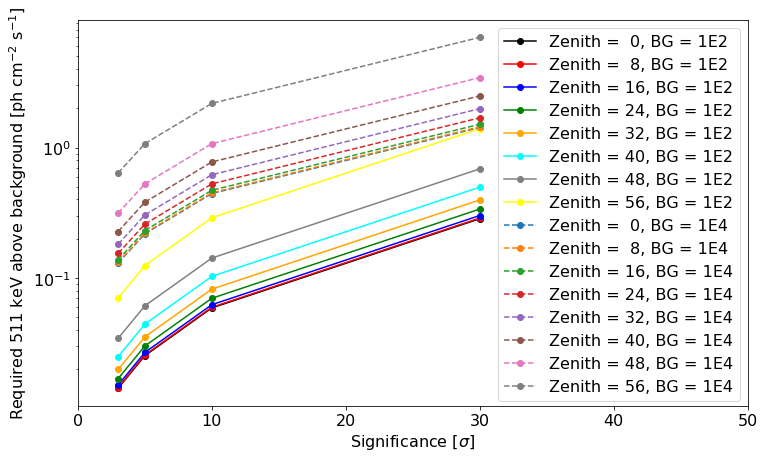

In [170]:
plt.figure(figsize=(12,7.1))
for a in range(2):
    for i in range(len(zeniths)):
        if a == 0:
            plt.plot(sigmas,fluxes_to_test[i,:,a],'o-',label=str('Zenith = %2i, BG = 1E2' % zeniths[i]))
        else:
            plt.plot(sigmas,fluxes_to_test[i,:,a],'o--',label=str('Zenith = %2i, BG = 1E4' % zeniths[i]))
plt.xlabel('Significance [$\sigma$]')
plt.ylabel('Required 511 keV above background [ph cm$^{-2}$ s$^{-1}$]')
plt.yscale('log')
plt.legend()
plt.xlim(0,50)

<h3>Now loop over all things and get parameters and uncertainties out to check if positions are consistently found:</h3>

In [171]:
fluxes_to_test.shape

(8, 4, 2)

In [176]:
Nbg = 2

A = np.array([Abg_lo,Abg_hi])

positions = np.zeros((Nbg,len(sigmas),len(zeniths),2))
actual_counts = np.zeros((Nbg,len(sigmas),len(zeniths)))
fit_pars = np.zeros((Nbg,len(sigmas),len(zeniths),4))
fit_errs = np.zeros((Nbg,len(sigmas),len(zeniths),4))



for n in tqdm(range(Nbg)):
    for s in tqdm(range(len(sigmas))):
        for z in tqdm(range(len(zeniths))):
            # get random point on zenith circle
            tmp_circle = np.column_stack(circle_on_the_sky(l0,b0,zeniths[z]))
            tmp_randp = tmp_circle[np.random.randint(100,size=1)[0],:]
            positions[n,s,z,:] = tmp_randp
            # calc zeniths and azimuths for observation pointings
            zens,azis = zenazi(xs[:,0],xs[:,1],
                               ys[:,0],ys[:,1],
                               zs[:,0],zs[:,1],
                               tmp_randp[0],tmp_randp[1])
            # calculate response for a source there
            tmp_sky_response = np.mean(get_response_with_weights(NonZeroResponseGrid,zens,azis,cut=60),axis=0)
            # scale by Tobs and flux given zenith and significance
            tmp_data = np.random.poisson(tmp_sky_response*fluxes_to_test[z,s,n]*Tobs0 + background_response*A[n])
            actual_counts[n,s,z] = np.sum(tmp_data)
            
            # fit
            ndim, nwalkers = 4, 20
            guess = np.array([fluxes_to_test[z,s,n],A[n], tmp_randp[0], tmp_randp[1]])
            pos = guess[:, None] + np.random.randn(ndim,nwalkers)*np.repeat([1e-4,1,1,1],nwalkers).reshape(ndim,nwalkers)
            pos = pos.T
            # make sure using the right observation
            zs = np.rad2deg(COSI_Data_sim_nova9[0]['Zpointings'])
            xs = np.rad2deg(COSI_Data_sim_nova9[0]['Xpointings'])
            ys = np.rad2deg(COSI_Data_sim_nova9[0]['Ypointings'])
            # set up sampler
            sampler = emcee.EnsembleSampler(nwalkers,
                                            ndim,
                                            lnprob_PSsearchFlux,
                                            args=(tmp_data,
                                                  NonZeroResponseGrid,
                                                  xs,ys,zs,
                                                  background_response,
                                                  Tobs0,False)) # set up sampler
            
            _ = sampler.run_mcmc(pos, 200, progress=True) # sample
            # get fit parameters and unceratinties out:
            samplesf = sampler.flatchain
            fit_pars[n,s,z,:] = np.median(samplesf[2000:,:],axis=0) # nwalkers * 100 for hopefully converged chains
            fit_errs[n,s,z,:] = np.std(samplesf[2000:,:],axis=0)

100%|██████████| 200/200 [00:40<00:00,  4.23it/s]


100%|██████████| 200/200 [00:49<00:00,  3.86it/s]


100%|██████████| 200/200 [00:34<00:00,  5.37it/s]


100%|██████████| 200/200 [00:06<00:00, 29.37it/s]


100%|██████████| 200/200 [00:23<00:00,  6.74it/s]


100%|██████████| 200/200 [00:49<00:00,  3.73it/s]


100%|██████████| 200/200 [00:59<00:00,  3.21it/s]


100%|██████████| 200/200 [00:19<00:00,  7.86it/s]


In [177]:
fit_pars[0,3,0,:]

array([  0.2756436 , 111.28577801,  10.03925073,   5.3943072 ])

<ErrorbarContainer object of 3 artists>

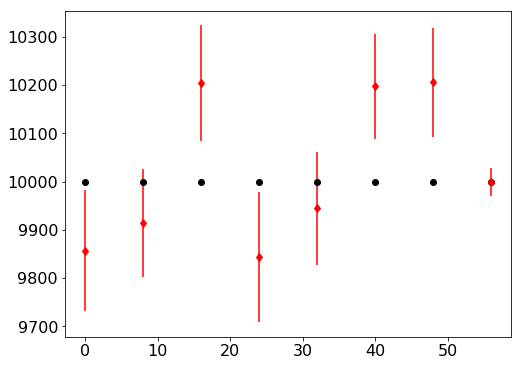

In [184]:
plt.plot(zeniths,np.repeat(A[1],len(zeniths)),'ko')
plt.errorbar(zeniths,fit_pars[1,3,:,1],yerr=fit_errs[1,3,:,1],fmt='dr')

<ErrorbarContainer object of 3 artists>

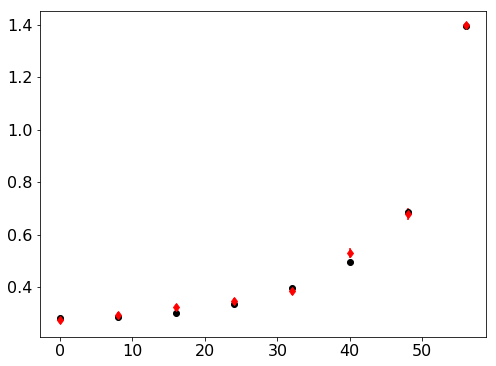

In [185]:
plt.plot(zeniths,fluxes_to_test[:,3,0],'ko')
plt.errorbar(zeniths,fit_pars[0,3,:,0],yerr=fit_errs[0,3,:,0],fmt='dr')

<ErrorbarContainer object of 3 artists>

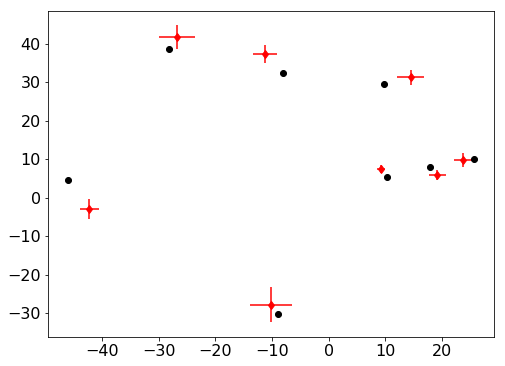

In [205]:
b = 0
s = 1
plt.plot(positions[b,s,:,0],positions[b,s,:,1],'ko')
plt.errorbar(fit_pars[b,s,:,2],fit_pars[b,s,:,3],xerr=fit_errs[b,s,:,2],yerr=fit_errs[b,s,:,3],fmt='dr')

In [ ]:
b = 0
s = 3

fmts_lo = ['ko','ro','bo','go']
fmts_hi = ['kd','rd','bd','gd']

plt.figure(figsize=(12,6))

for s in range(4):
    b = 0
    dist = angular_distance(positions[b,s,:,0],positions[b,s,:,1],fit_pars[b,s,:,2],fit_pars[b,s,:,3],deg=True)
    dist_err = np.sqrt(fit_errs[b,s,:,2]**2+fit_errs[b,s,:,3]**2)
    plt.errorbar(zeniths-2+s,dist/dist_err,yerr=dist_err/dist_err,fmt=fmts_lo[s],label=str('%2i$\sigma$' % sigmas[s]))
    plt.text(65,0.5,'BG lo',horizontalalignment='center',verticalalignment='center')
    
    b = 1
    dist = -angular_distance(positions[b,s,:,0],positions[b,s,:,1],fit_pars[b,s,:,2],fit_pars[b,s,:,3],deg=True)
    dist_err = np.sqrt(fit_errs[b,s,:,2]**2+fit_errs[b,s,:,3]**2)
    plt.text(65,-0.5,'BG hi',horizontalalignment='center',verticalalignment='center')
    eb = plt.errorbar(zeniths-2+s,dist/dist_err,yerr=dist_err/dist_err,fmt=fmts_hi[s])
    eb[-1][0].set_linestyle('--')
plt.hlines(0,-10,1e2,linestyle='--')
plt.xlim(-5,70)
plt.xlabel('Zenith [deg]')
plt.ylabel('Off localisation [$\sigma$]')
plt.legend()